In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [41]:
# 采用交错网格
def init_con(nx, ny, len_x=2, len_y=2):
    dx = len_x / (nx - 1)
    dy = len_y / (ny - 1)
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    return u, v, p, dx, dy

class PrjMethod(object):
    def __init__(self, u, v, p, re, dx, dy, dt=0.1, max_iter=10000, epsion=1e-9):
        self.u = u
        self.v = v
        self.p = p
        self.re = re
        self.dx = dx
        self.dy = dy
        self.dt = dt
        self.max_iter= max_iter
        self.epsion= epsion
    
    def __set_bnd(self):
        self.u[0, :] = 2
        self.u[1:, 0] = 0
        self.u[1:, -1] = 0
        self.u[-1, :] = 0
        self.v[-1, :] = 0
        self.v[0, :] = 0
        self.v[:, 0] = 0
        self.v[:, -1] = 0
        
    # 速度3阶迎风格式(对流项)
    def __partial_var(self, var, is_pos):
        par_var_x = np.zeros_like(var)
        par_var_y = np.zeros_like(var)
        if is_pos:
            par_var_x[:, 2:-1] = (2 * var[:, 3:] + 3 * var[:, 2:-1] -
                                6 * var[:, 1:-2] + var[:, 0:-3])/6/self.dx
            par_var_y[2:-1, :] = (2 * var[3:, :] + 3 * var[2: -1, :] -
                                6 * var[1:-2, :] + var[0:-3, :])/6/self.dy
        else:
            par_var_x[:, 1:-2] = (-1 * var[:, 3:] + 6 * var[:, 2:-1] -
                                3 * var[:, 1:-2] -2 * var[:, 0:-3])/6/self.dx
            par_var_y[1:-2, :] = (-1 * var[3:, :] + 6 * var[2: -1, :] -
                                3 * var[1:-2, :] -2 * var[0:-3, :])/6/self.dy
        return par_var_x, par_var_y
            

    # 压强2阶中心差分
    def __partial_pressure(self):
        p_press_x = np.zeros_like(self.p)
        p_press_y = np.zeros_like(self.p)
        p_press_x[1:-1, 1:-1] = (self.p[1:-1, 2:] - self.p[1:-1, 0:-2])/self.dx
        p_press_y[1:-1, 1:-1] = (self.p[2:, 1:-1] - self.p[0:-2, 1:-1])/self.dy
        return p_press_x, p_press_y

    # 扩散项2阶中心差分
    def __partial2_var(self, var):
        par2_var_x = np.zeros_like(var)
        par2_var_y = np.zeros_like(var)
        par2_var_x[:, 1:-1] = (var[:, 2:] - 2 * var[:, 1:-1] + var[:, 0:-2])/self.dx/self.dx
        par2_var_y[1:-1, :] = (var[2:, :] - 2 * var[1:-1, :] + var[0:-2, :])/self.dy/self.dy
        return par2_var_x, par2_var_y
        
    def __get_var_star(self, var):
       p_var_x_pos, p_var_y_pos = self.__partial_var(var, True) 
       p_var_x_neg, p_var_y_neg = self.__partial_var(var, False) 
       convec = 0.5 * (self.u + np.abs(self.u)) * p_var_x_pos + 0.5 * (self.u - np.abs(self.u)
                ) * p_var_x_neg + 0.5 * (self.v + np.abs(self.v)) * p_var_y_pos + 0.5 * (self.v -
                np.abs(self.v)) * p_var_y_neg
    #    convec = self.u * p_var_x_pos + self.v * p_var_y_pos
       par2_var_x, par2_var_y = self.__partial2_var(var)
       var_star = var.copy()
       var_star[1:-1, 1:-1] = var[1:-1, 1:-1] + self.dt * ((par2_var_x[1:-1, 1:-1] + par2_var_y[1:-1, 1:-1])/self.re - convec[1:-1, 1:-1])
       return var_star
    
    def __get_V_star(self):
        u_star = self.__get_var_star(self.u)
        v_star = self.__get_var_star(self.v)
        return u_star, v_star
    
    def __is_converged(self, delta):
        error = np.linalg.norm(delta, ord=np.inf)
        # print(error)
        if error < self.epsion:
            return True
        return False
        
    # 求解Poisson方程,Jacobi迭代
    def __calc_p(self, u_star, v_star):
        par_u_star_x, _ = self.__partial_var(u_star, True)
        _, par_v_star_y = self.__partial_var(v_star, True)
        right_item = (par_u_star_x + par_v_star_y)/self.dt
        is_converged = False
        while not is_converged:
            p1 = np.zeros_like(self.p)
            p2 = np.zeros_like(self.p)
            p = np.zeros_like(self.p)
            p1[1:-1, 1:-1] = self.dy * self.dy * (self.p[1:-1, 2:] + self.p[1:-1, 0:-2])
            p2[1:-1, 1:-1] = self.dx * self.dx * (self.p[2:, 1:-1] + self.p[0:-2, 1:-1])
            p[1:-1, 1:-1] = (p1[1:-1, 1:-1] + p2[1:-1, 1:-1] - right_item[1:-1, 1:-1] * self.dx * self.dx * self.dy * self.dy)/(
                2 * self.dx * self.dx + 2 * self.dy * self.dy)
            p[:, 0] = p[:, 1]
            p[:, -1] = p[:, -2]
            p[-1, :] = 0
            p[0, :] = p[1, :]
            delta = p - self.p 
            is_converged = self.__is_converged(delta)
            self.p = p
        print('shoulian')
        return
        
    def __step_V(self):
        u_star, v_star = self.__get_V_star()
        self.__calc_p(u_star, v_star)
        p_pressure_x, p_pressure_y = self.__partial_pressure()
        self.u[1:-1, 1:-1] = u_star[1:-1, 1:-1] - self.dt * p_pressure_x[1:-1, 1:-1]
        self.v[1:-1, 1:-1] = v_star[1:-1, 1:-1] - self.dt * p_pressure_y[1:-1, 1:-1]
        self.u[0, :] = 0
        self.u[-1, :] = 2
        self.u[1:-1, 0] = 0
        self.u[1:-1, -1] = 0
        self.v[0, :] = 0
        self.v[-1, :] = 0
        self.v[:, 0] = 0
        self.v[:, -1] = 0
        return
        
    def get_solu(self):
        for _ in range(self.max_iter):
            old_u = self.u.copy()
            old_v = self.v.copy()
            self.__step_V()
            # print(self.u)
            delta_u = old_u - self.u
            delta_v = old_v - self.v
            if self.__is_converged(delta_u) & self.__is_converged(delta_v):
                return
        print("Not converged after {} iterator!".format(self.max_iter))
        return -1


In [42]:
# 生成网格存储
u, v, p, dx, dy = init_con(11, 11)
u[0, :] = 2
re = 400
prjmethod = PrjMethod(u, v, p, re, dx, dy, dt=0.001, max_iter=50)
prjmethod.get_solu()

shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
shoulian
Not converged after 50 iterator!


-1

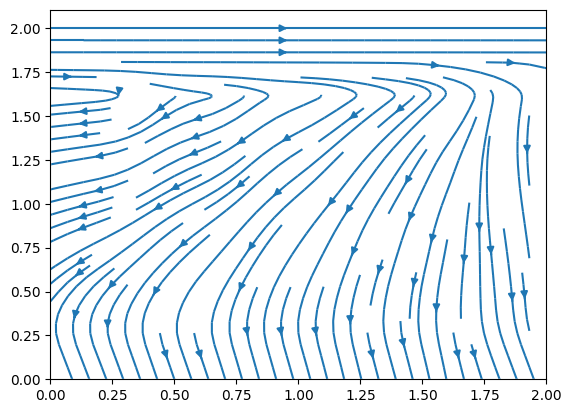

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.linspace(0, 2, 11, endpoint=True)
y = np.linspace(0, 2, 11, endpoint=True)
X, Y = np.meshgrid(x, y)
ax.streamplot(X, Y, prjmethod.u, prjmethod.v)
# aa = ax.contour(X, Y, prjmethod.u)
# fig.colorbar(aa)

In [32]:
prjmethod.v

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , 18.45937846, 18.46296914, 18.46070996, 18.4625572 ,
        18.46240087, 18.46446353, 18.46586085, 18.46807804, 18.47421269,
         0.        ],
       [ 0.        , 14.61409823, 14.6047897 , 14.61513789, 14.61226344,
        14.61545601, 14.6124869 , 14.61008515, 14.60318403, 14.58261705,
         0.        ],
       [ 0.        ,  6.81721631,  6.81403904,  6.81784114,  6.81709165,
         6.81844563,  6.81752295,  6.81688474,  6.81476176,  6.80834687,
         0.        ],
       [ 0.        ,  2.54602335,  2.54321556,  2.54610142,  2.54400961,
         2.54527916,  2.54251212,  2.54076576,  2.53650309,  2.53081819,
         0.        ],
       [ 0.        ,  0.19466107,  0.19355308,  0.1940822 ,  0.19320585,
         0.1935528 ,  0.19260388,  0.19258599,  0.1916936 ,  0.19111797,
         0.   